# Finding optimal parameters

In [1]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import product
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

# Custom modules
from src.utils.loader import DataLoader
from src.utils.nlp import process_evaluation_set
from src.features.sentiment import SentimentFeatures
from src.features.concepts import ConceptExtractor
from src.models.classic import LinearSVMClassifier, LogisticRegressionClassifier

from joblib import Parallel, delayed


In [3]:
# Static parameters
MAX_DF_RATIO = 0.5
MIN_TERM_FREQ = 10
LOWER_CONFIDENCE_THRESHOLD = 0.3
TRAIN_SIZE = 0.5
TEST_SIZE = 0.8
BERT_ACCURACY_ESTIMATE = 0.8

# --- DATA LOADING (Once) ---
loader = DataLoader()
train, _, test = loader.load_imdb(train_size=TRAIN_SIZE, test_size=TEST_SIZE)

# --- CLEANUP ---
# Remove 'clean_review' to save memory
for item in train:
    item.pop('clean_review', None)
    
for item in test:
    item.pop('clean_review', None)

Loading IMDb reviews...


I0000 00:00:1767944200.239268    1222 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Cleaning 49582 reviews...


  0%|          | 0/49582 [00:00<?, ?it/s]

Loaded dataset with 24791 train, 4958 val and 19833 test samples.

--- TRAIN SET (Total: 24791 reviews) ---


,review,clean_review,clean_bow,sentiment
0,"I first saw this one when it was first shown, ...","I first saw this one when it was first shown, ...","i first saw this one when it was first shown, ...",1
1,I first watched Kindred in 1987 along with ano...,I first watched Kindred in 1987 along with ano...,i first watched kindred in 1987 along with ano...,0
2,Wasn't sure what to expect from this film. I l...,Wasn't sure what to expect from this film. I l...,was not sure what to expect from this film. i ...,1
3,"Someone(or, something thing..)is leaving punct...","Someone(or, something thing..)is leaving punct...","someone(or, something thing..)is leaving punct...",1
4,"I seldom see a film with such a cast, such a p...","I seldom see a film with such a cast, such a p...","i seldom see a film with such a cast, such a p...",0



--- VALIDATION SET (Total: 4958 reviews) ---


,review,clean_review,clean_bow,sentiment
0,"I have recently watched this film, and have de...","I have recently watched this film, and have de...","i have recently watched this film, and have de...",1
1,Where do I start? The box should have been eno...,Where do I start? The box should have been eno...,where do i start? the box should have been eno...,0
2,"How dare you? Adam Low, without apparent shame...","How dare you? Adam Low, without apparent shame...","how dare you? adam low, without apparent shame...",0
3,I was very excited to see a documentary on one...,I was very excited to see a documentary on one...,i was very excited to see a documentary on one...,1
4,Jeff Garlin's film is filled with heart and la...,Jeff Garlin's film is filled with heart and la...,jeff garlin's film is filled with heart and la...,1



--- TEST SET (Total: 19833 reviews) ---


,review,clean_review,clean_bow,sentiment
0,This film about secret government mind experim...,This film about secret government mind experim...,this film about secret government mind experim...,0
1,"While the movie has its flaws, it brings to li...","While the movie has its flaws, it brings to li...","while the movie has its flaws, it brings to li...",1
2,This has got to be one of the weakest plots in...,This has got to be one of the weakest plots in...,this has got to be one of the weakest plots in...,0
3,Police officer Dirk Hendricks (Jamie Bartlett)...,Police officer Dirk Hendricks (Jamie Bartlett)...,police officer dirk hendricks (jamie bartlett)...,1
4,My husband and I enjoy The DoodleBops as much ...,My husband and I enjoy The DoodleBops as much ...,my husband and i enjoy the doodlebops as much ...,1


Saved train set to data/IMDb/train.json
Saved val set to data/IMDb/val.json
Saved test set to data/IMDb/test.json


In [4]:
import gc
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from joblib import Parallel, delayed

# --- WORKER FUNCTION FOR THREADING ---
# This runs in a thread. It reads 'train_ids'/'test_ids' directly from shared memory.
# No copying occurs because we use backend="threading".
def train_and_eval_worker(z_thresh, model_cls, n_concepts, ngram_range, 
                          train_ids, test_ids, y_train, y_test, sf_stats):
    
    # 1. Filter Features (Locally in thread)
    # Re-calculate importance set for this Z-threshold
    top_pos = set(sf_stats[1][sf_stats[1]['zscore'] > z_thresh]['concept'])
    top_neg = set(sf_stats[0][sf_stats[0]['zscore'] > z_thresh]['concept'])
    important_set = top_pos | top_neg
    
    # Filter the integer lists (Fast, creates small temporary lists)
    X_train_filtered = [[c for c in row if c in important_set] for row in train_ids]
    X_test_filtered = [[c for c in row if c in important_set] for row in test_ids]
    
    # 2. Vectorize (TF-IDF)
    # We use a dummy analyzer because we already have integer tokens
    pipeline = Pipeline([
        ('vect', CountVectorizer(analyzer=lambda x: x, lowercase=False)),
        ('tfidf', TfidfTransformer())
    ])
    
    try:
        X_train_tfidf = pipeline.fit_transform(X_train_filtered)
        X_test_tfidf = pipeline.transform(X_test_filtered)
    except ValueError:
        return None # Handle empty vocab

    if X_train_tfidf.shape[1] == 0:
        return None

    # 3. Train & Evaluate
    model_name = "SVM" if "SVM" in model_cls.__name__ else "LogReg"
    model = model_cls(name=model_cls.__name__)
    
    # The Heavy Lifting (GIL is released here, allowing parallelism)
    model.train(X_train_tfidf, y_train)
    probs, preds = model.evaluate(X_test_tfidf, y_test, lower_threshold=0.0, plotting=False)

    # 4. Metrics
    preds_np = np.array(preds)
    y_test_np = np.array(y_test)
    probs_np = np.array(probs)

    certain_mask = (probs_np < LOWER_CONFIDENCE_THRESHOLD) | (probs_np > (1 - LOWER_CONFIDENCE_THRESHOLD))
    total_acc = np.mean(preds_np == y_test_np)
    coverage = np.mean(certain_mask)
    certain_acc = np.mean(preds_np[certain_mask] == y_test_np[certain_mask]) if coverage > 0 else 0.0
    optimization_score = certain_acc * coverage - (BERT_ACCURACY_ESTIMATE * (1-coverage))

    return {
        "STD_DEV_Z": z_thresh,
        "N_GRAM_RANGE": ngram_range,
        "NUMBER_CONCEPTS": n_concepts,
        "model": model_name,
        "total_accuracy": total_acc,
        "certain_accuracy": certain_acc,
        "coverage": coverage,
        "optimization_score": optimization_score,
        "ngrams_str": str(ngram_range)
    }

# --- MAIN EXECUTION ---
param_grid = {
    'STD_DEV_Z': [0, 1.0, 1.96, 2.576],
    'N_GRAM_RANGE': [(1, 1), (1, 2), (1, 3)],
    'NUMBER_CONCEPTS': [0, 500, 1000],
    'MODELS': [LinearSVMClassifier, LogisticRegressionClassifier]
}

results = []
print(f"{'='*60}\nSTARTING SHARED-MEMORY PARALLEL SEARCH\n{'='*60}")

# 1. OUTER LOOP: N-GRAMS (Sequential - Memory Heavy)
for ngram_range in param_grid['N_GRAM_RANGE']:
    print(f"\n[N-GRAM] Processing {ngram_range}...")
    
    # --- Generate N-Grams & Map to Integers ---
    # (Generating dictionary and base_map...)
    df_by_label = defaultdict(Counter)
    for item in train:
        units = set(DataLoader.get_ngrams(item['clean_bow'], ngram_range=ngram_range))
        df_by_label[item['sentiment']].update(units)

    n_docs_label = Counter(item['sentiment'] for item in train)
    stop_sets = [{u for u, c in df_by_label[l].items() if c > n_docs_label[l] * MAX_DF_RATIO} for l in df_by_label]
    stop_units = set.intersection(*stop_sets) if stop_sets else set()
    del df_by_label
    
    tf_counts = Counter()
    for item in train:
        tf_counts.update([u for u in DataLoader.get_ngrams(item['clean_bow'], ngram_range=ngram_range) if u not in stop_units])
    
    unique_units = sorted([u for u, c in tf_counts.items() if c >= MIN_TERM_FREQ])
    base_map = {u: i for i, u in enumerate(unique_units)}
    del tf_counts
    gc.collect()

    print(f"  > Mapped {len(base_map)} unique units. Digitizing data...")
    
    # Convert Text Strings to Integers (Shared Memory Source)
    train_base_ids = []
    for item in train:
        train_base_ids.append([base_map[u] for u in DataLoader.get_ngrams(item['clean_bow'], ngram_range=ngram_range) if u in base_map])
        
    test_raw_units_list = []
    for item in test:
        test_raw_units_list.append([u for u in DataLoader.get_ngrams(item['clean_bow'], ngram_range=ngram_range) if u not in stop_units])

    # 2. MIDDLE LOOP: CONCEPTS (Sequential - Memory Heavy)
    for n_concepts in param_grid['NUMBER_CONCEPTS']:
        print(f"    [CONCEPTS] {n_concepts} clusters...")
        
        if n_concepts > 0:
            extractor = ConceptExtractor()
            res = extractor.train_concepts(set(unique_units), n_clusters=n_concepts, printing=False)
            u2c = res['unit_to_cluster']
            c_centers = res['cluster_centers']
            
            # ID Remapping
            base_id_to_concept = {base_map[u]: u2c[u] for u in u2c if u in base_map}
            
            current_train_ids = [[base_id_to_concept[b] for b in row if b in base_id_to_concept] for row in train_base_ids]
            
            # Test set mapping (Unknown handling)
            test_counts = Counter()
            for row in test_raw_units_list: test_counts.update(row)
            unknowns = [u for u in test_counts if u not in base_map and test_counts[u] >= MIN_TERM_FREQ]
            unknown_map = extractor.map_units_to_clusters(unknowns, c_centers, printing=False) if unknowns else {}
            
            current_test_ids = []
            for row in test_raw_units_list:
                mapped = []
                for u in row:
                    if u in base_map and base_map[u] in base_id_to_concept: mapped.append(base_id_to_concept[base_map[u]])
                    elif u in unknown_map: mapped.append(unknown_map[u])
                current_test_ids.append(mapped)
        else:
            current_train_ids = train_base_ids
            current_test_ids = [[base_map[u] for u in row if u in base_map] for row in test_raw_units_list]

        # Calculate Stats ONCE (Shared by all threads)
        sf = SentimentFeatures()
        y_train_labels = [item['sentiment'] for item in train]
        sf.fit(current_train_ids, y_train_labels)
        sf_stats = sf.logodds_per_class # Pass this read-only dict
        
        y_test_labels = [item['sentiment'] for item in test]

        # 3. INNER PARALLEL LOOP (Computation Heavy - Parallel safe)
        # backend="threading" shares memory. No copying of current_train_ids.
        print(f"      > Parallel training ({len(param_grid['STD_DEV_Z']) * len(param_grid['MODELS'])} jobs)...")
        
        batch_results = Parallel(n_jobs=4, backend="threading")(
            delayed(train_and_eval_worker)(
                z, m, n_concepts, ngram_range,
                current_train_ids, current_test_ids, # Shared Lists
                y_train_labels, y_test_labels, sf_stats
            )
            for z in param_grid['STD_DEV_Z']
            for m in param_grid['MODELS']
        )
        
        results.extend([r for r in batch_results if r is not None])

    del base_map, train_base_ids
    gc.collect()

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['optimization_score'].idxmax()]
print(f"Best Score: {best['optimization_score']:.4f}")

STARTING SHARED-MEMORY PARALLEL SEARCH

[N-GRAM] Processing (1, 1)...
  > Mapped 19864 unique units. Digitizing data...
    [CONCEPTS] 0 clusters...
      > Parallel training (8 jobs)...
    [CONCEPTS] 500 clusters...
      > Parallel training (8 jobs)...
    [CONCEPTS] 1000 clusters...


WARNING clustering 19864 points to 1000 centroids: please provide at least 39000 training points


      > Parallel training (8 jobs)...

[N-GRAM] Processing (1, 2)...
  > Mapped 91768 unique units. Digitizing data...
    [CONCEPTS] 0 clusters...
      > Parallel training (8 jobs)...
    [CONCEPTS] 500 clusters...
      > Parallel training (8 jobs)...
    [CONCEPTS] 1000 clusters...
      > Parallel training (8 jobs)...

[N-GRAM] Processing (1, 3)...
  > Mapped 150743 unique units. Digitizing data...
    [CONCEPTS] 0 clusters...
      > Parallel training (8 jobs)...
    [CONCEPTS] 500 clusters...
      > Parallel training (8 jobs)...
    [CONCEPTS] 1000 clusters...
      > Parallel training (8 jobs)...
Best Score: 0.7734


In [48]:
best

STD_DEV_Z                  1.0
N_GRAM_RANGE            (1, 3)
NUMBER_CONCEPTS              0
model                      SVM
total_accuracy        0.913276
certain_accuracy      0.947961
coverage              0.900116
optimization_score    0.773368
ngrams_str              (1, 3)
Name: 50, dtype: object

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

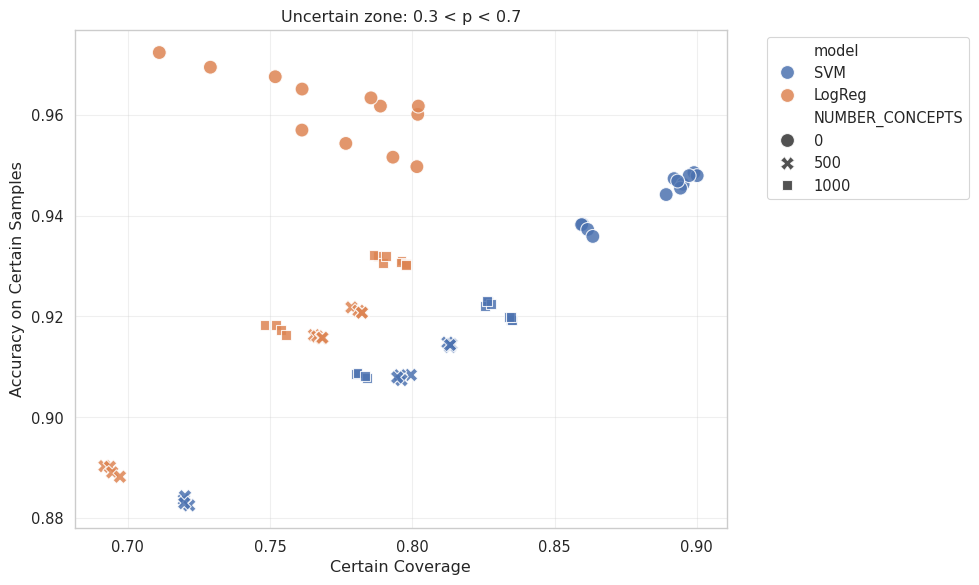

In [57]:
# =========================
# SYSTEM-LEVEL COMPARISON
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))

# Scatter: selective model performance
sns.scatterplot(
    data=results_df,
    x="coverage",
    y="certain_accuracy",
    hue="model",
    style="NUMBER_CONCEPTS",
    s=100,
    alpha=0.85
)

plt.title(
    f"Uncertain zone: 0.3 < p < 0.7"
)
plt.xlabel("Certain Coverage")
plt.ylabel("Accuracy on Certain Samples")

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure consistent styling
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# Convert n-grams to string if not already
results_df['ngrams_str'] = results_df['N_GRAM_RANGE'].apply(lambda x: str(x))

# Create a clean 'Concept Label' for legends
results_df['Concept Configuration'] = results_df['NUMBER_CONCEPTS'].apply(
    lambda x: "No Concepts" if x == 0 else f"{x} Concepts"
)

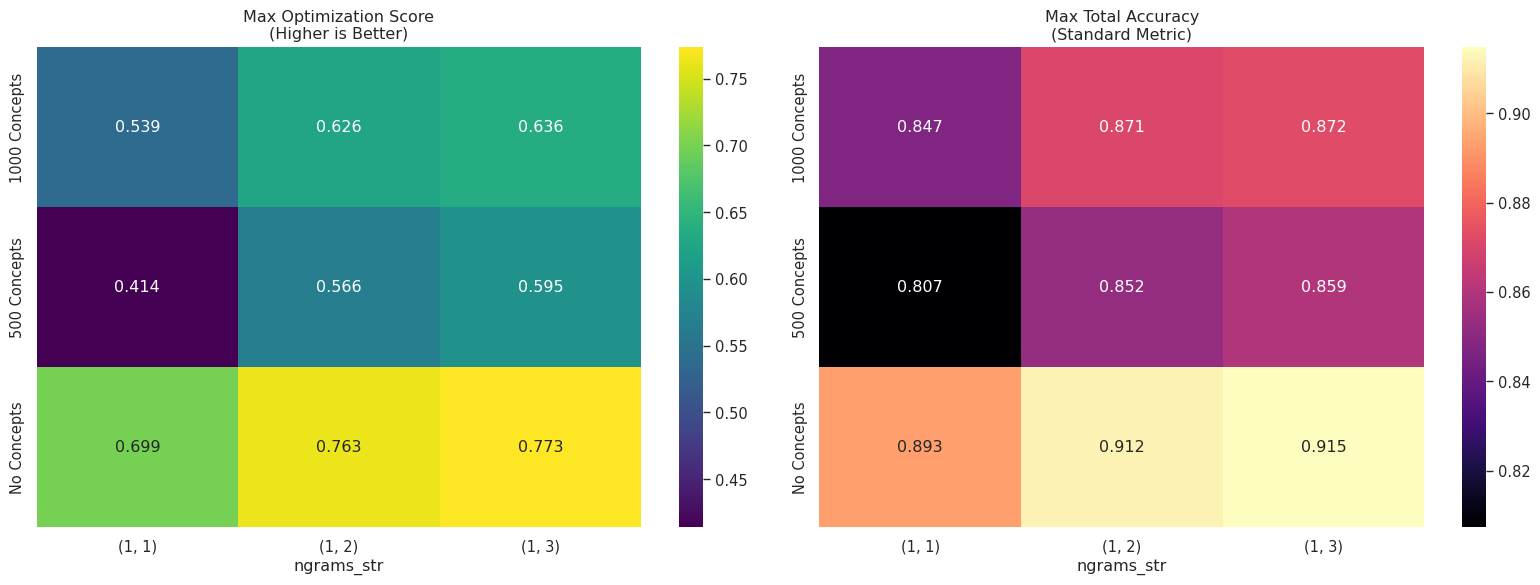

In [15]:
# Create pivot tables aggregating by the MAXIMUM score achieved for that config
# (We take the max across models and Z-scores to see the potential of the structure)
pivot_opt = results_df.pivot_table(
    index='Concept Configuration', 
    columns='ngrams_str', 
    values='optimization_score', 
    aggfunc='max'
)

pivot_acc = results_df.pivot_table(
    index='Concept Configuration', 
    columns='ngrams_str', 
    values='total_accuracy', 
    aggfunc='max'
)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Optimization Score
sns.heatmap(pivot_opt, annot=True, fmt=".3f", cmap="viridis", ax=axes[0])
axes[0].set_title("Max Optimization Score\n(Higher is Better)")
axes[0].set_ylabel("")

# Plot 2: Total Accuracy
sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap="magma", ax=axes[1])
axes[1].set_title("Max Total Accuracy\n(Standard Metric)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

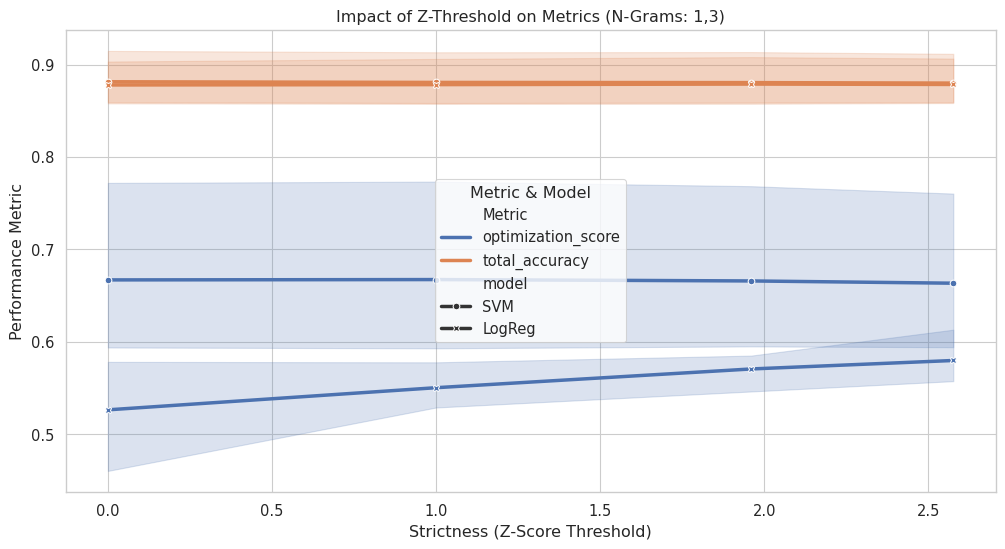

In [19]:
plt.figure(figsize=(12, 6))

# Filter for the best N-Gram model to simplify the view
# Or plot the average behavior
subset = results_df[results_df['ngrams_str'] == '(1, 3)']

# We melt the dataframe to plot two different metrics on the same Y-axis scale
melted = subset.melt(
    id_vars=['STD_DEV_Z', 'model'], 
    value_vars=['optimization_score', 'total_accuracy'],
    var_name='Metric', 
    value_name='Score'
)

sns.lineplot(
    data=melted,
    x='STD_DEV_Z', 
    y='Score', 
    hue='Metric',
    style='model',
    markers=True, 
    dashes=False,
    linewidth=2.5
)

plt.title("Impact of Z-Threshold on Metrics (N-Grams: 1,3)")
plt.xlabel("Strictness (Z-Score Threshold)")
plt.ylabel("Performance Metric")
plt.legend(title="Metric & Model")
plt.show()